# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
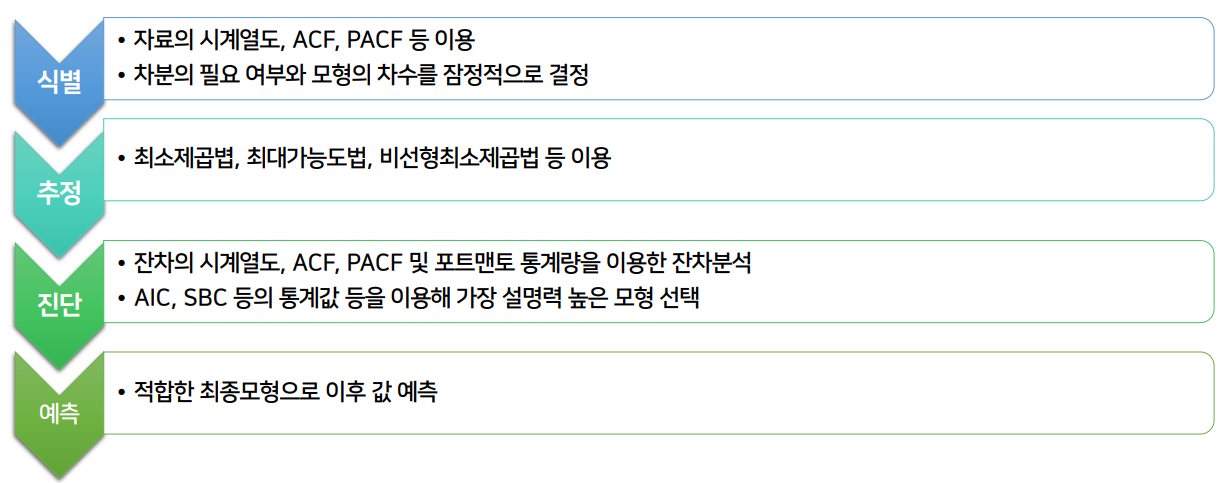

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults

C:\Users\pshpu\AppData\Local\Temp\ipykernel_14960\11377336.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 데이터 불러오기

In [9]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


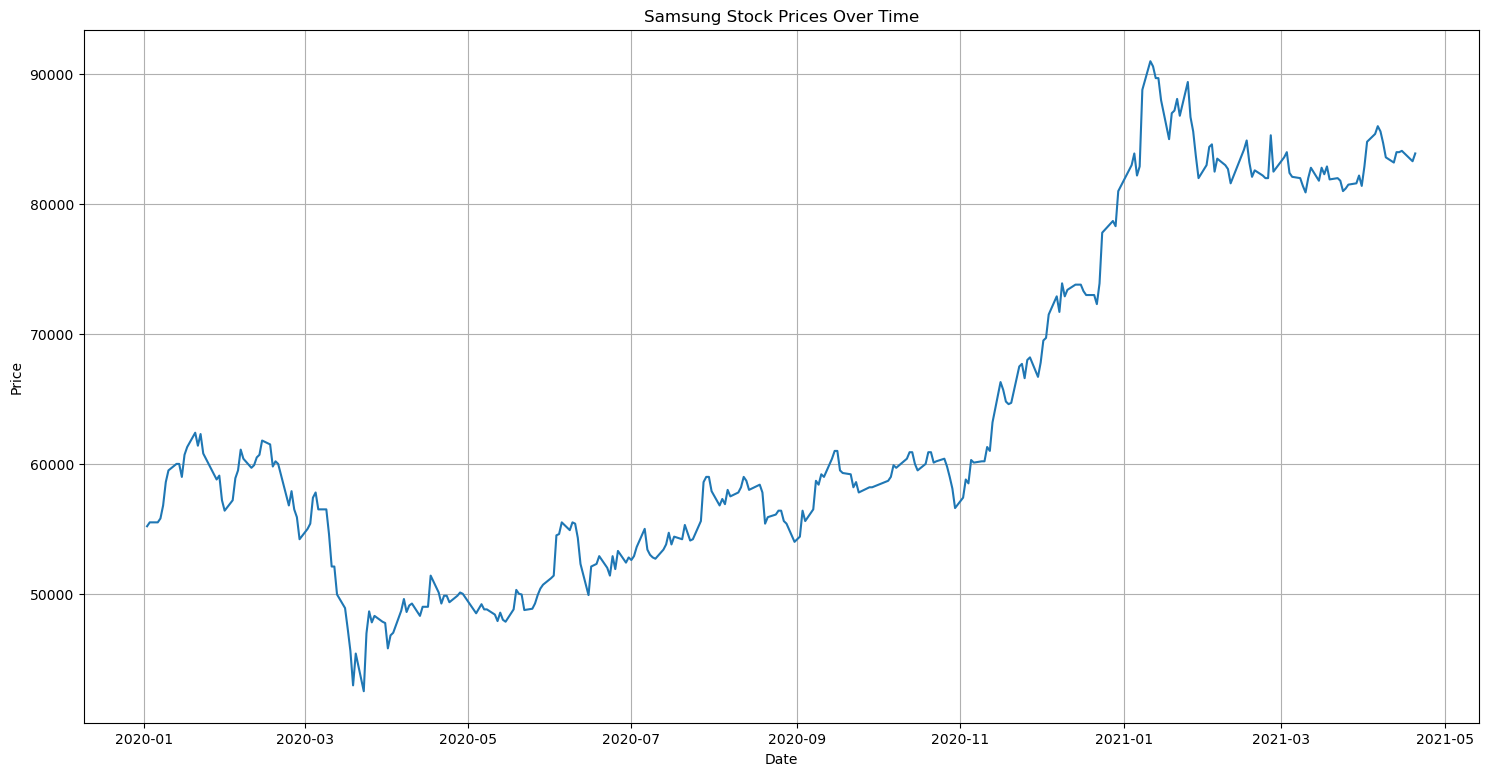

In [11]:
plt.figure(figsize=(18,9))
plt.plot(samsung_df.index, samsung_df['price'], linestyle="-")
plt.title('Samsung Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

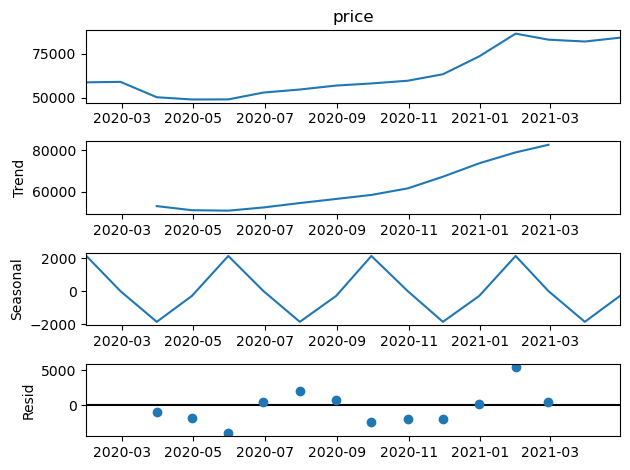

In [16]:
samsung_monthly = samsung_df.resample('M').mean()
# Decompose the resampled time series data with specified period
decomposition_monthly = seasonal_decompose(samsung_monthly['price'], model='additive', period=4)

# Plot the decomposed components
decomposition_monthly.plot()
plt.show()

In [17]:
# 데이터 정상성 확인
from statsmodels.tsa.stattools import adfuller, kpss

# Define a function to perform ADF and KPSS tests
def test_stationarity(timeseries):
    # Perform ADF test
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)
    print("\n")

    # Perform KPSS test
    print('Results of KPSS Test:')
    kpss_test = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpss_test[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpss_test[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)

# Test the stationarity of the data
test_stationarity(samsung_monthly['price'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                 2.411099
p-value                        0.999015
#Lags Used                     6.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


Results of KPSS Test:
Test Statistic           0.508629
p-value                  0.039723
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [18]:
# 비정상 확인, 차분 후 정상 상태로 만든 후 모델링 진행
# Take the first difference of the data to make it stationary
samsung_diff = samsung_monthly.diff().dropna()

# Test the stationarity of the differenced data
test_stationarity(samsung_diff['price'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -3.064604
p-value                         0.029286
#Lags Used                      1.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


Results of KPSS Test:
Test Statistic           0.2593
p-value                  0.1000
Lags Used                1.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical Value (1%)      0.7390
dtype: float64


C:\Users\pshpu\anaconda3\envs\senv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


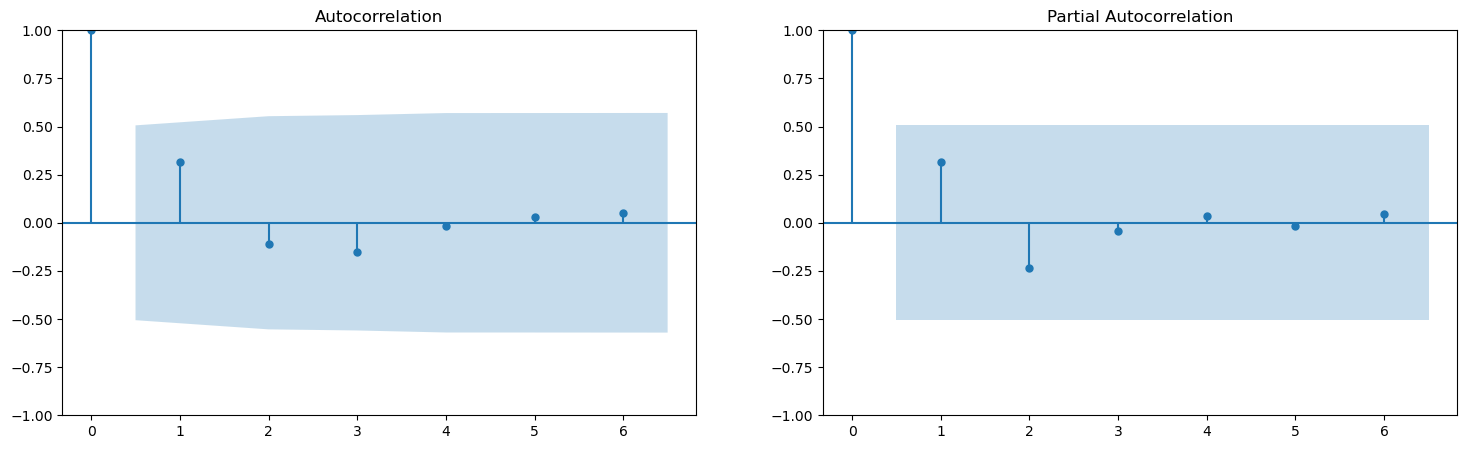

In [19]:
# ARIMA 모델의 적정 파라미터 결정 위해 ACF 및 PACF 그래프 시각화
# Plot ACF and PACF with adjusted nlags
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
plot_acf(samsung_diff, ax=ax[0], lags=6)
plot_pacf(samsung_diff, ax=ax[1], lags=6, method='ywmle')
plt.show()

C:\Users\pshpu\anaconda3\envs\senv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


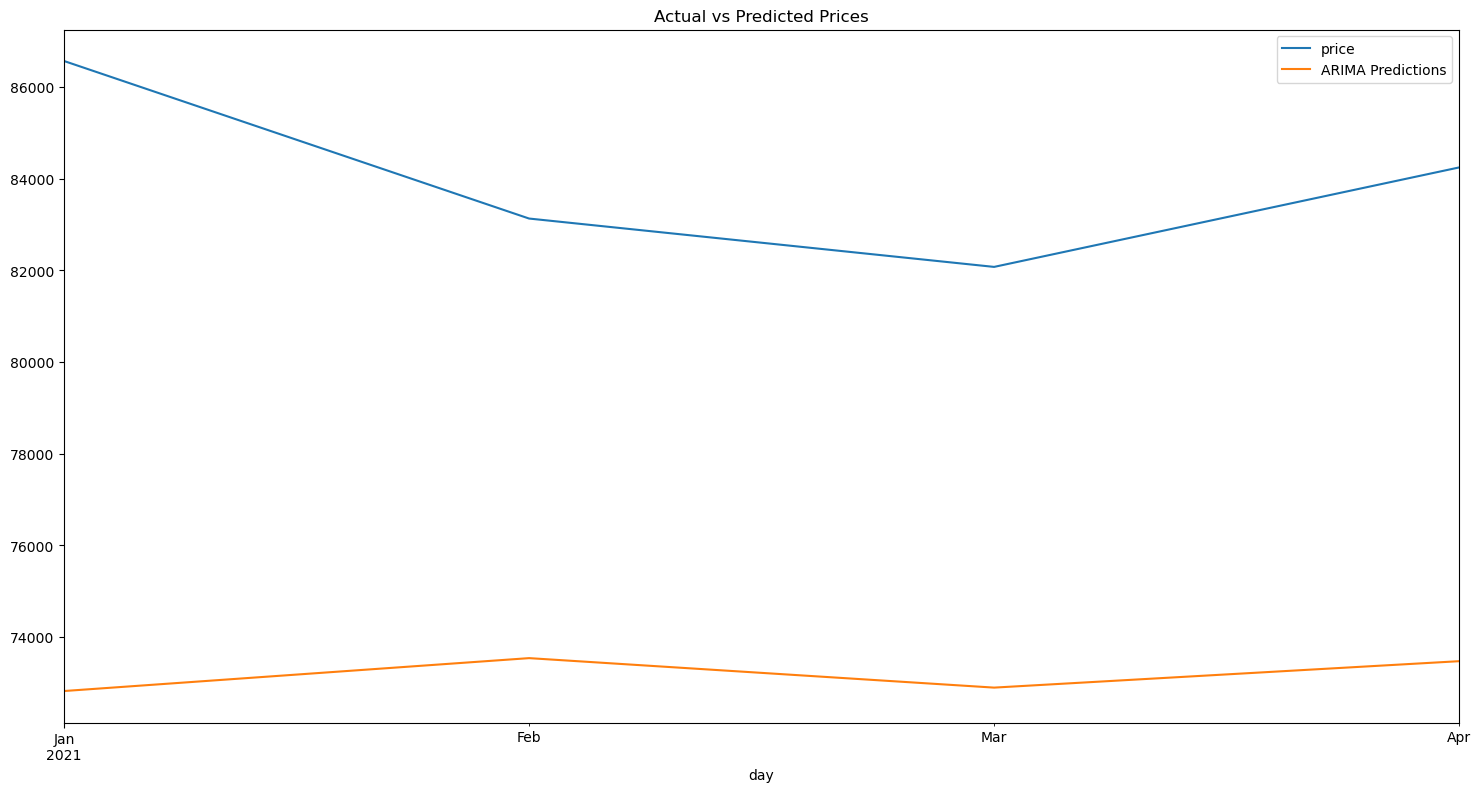

In [22]:
# Split the data into train and test sets
train_data = samsung_monthly.iloc[:-4]
test_data = samsung_monthly.iloc[-4:]

# Build and train the ARIMA model again
arima_model = ARIMA(train_data['price'], order=(1,1,1))
arima_result = arima_model.fit()

# Predict using the model
arima_pred = arima_result.predict(start=len(train_data), end=len(samsung_monthly)-1, typ="levels").rename("ARIMA Predictions")

# Plot the actual vs predicted values
plt.figure(figsize=(18,9))
test_data['price'].plot(legend=True)
arima_pred.plot(legend=True)
plt.title('Actual vs Predicted Prices')
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error

sarima_rmse_error = np.sqrt(mean_squared_error(test_data['price'], arima_pred))
sarima_mse_error = sarima_rmse_error**2

sarima_mse_error, sarima_rmse_error

(120327589.64756604, 10969.393312647971)

C:\Users\pshpu\anaconda3\envs\senv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\pshpu\anaconda3\envs\senv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


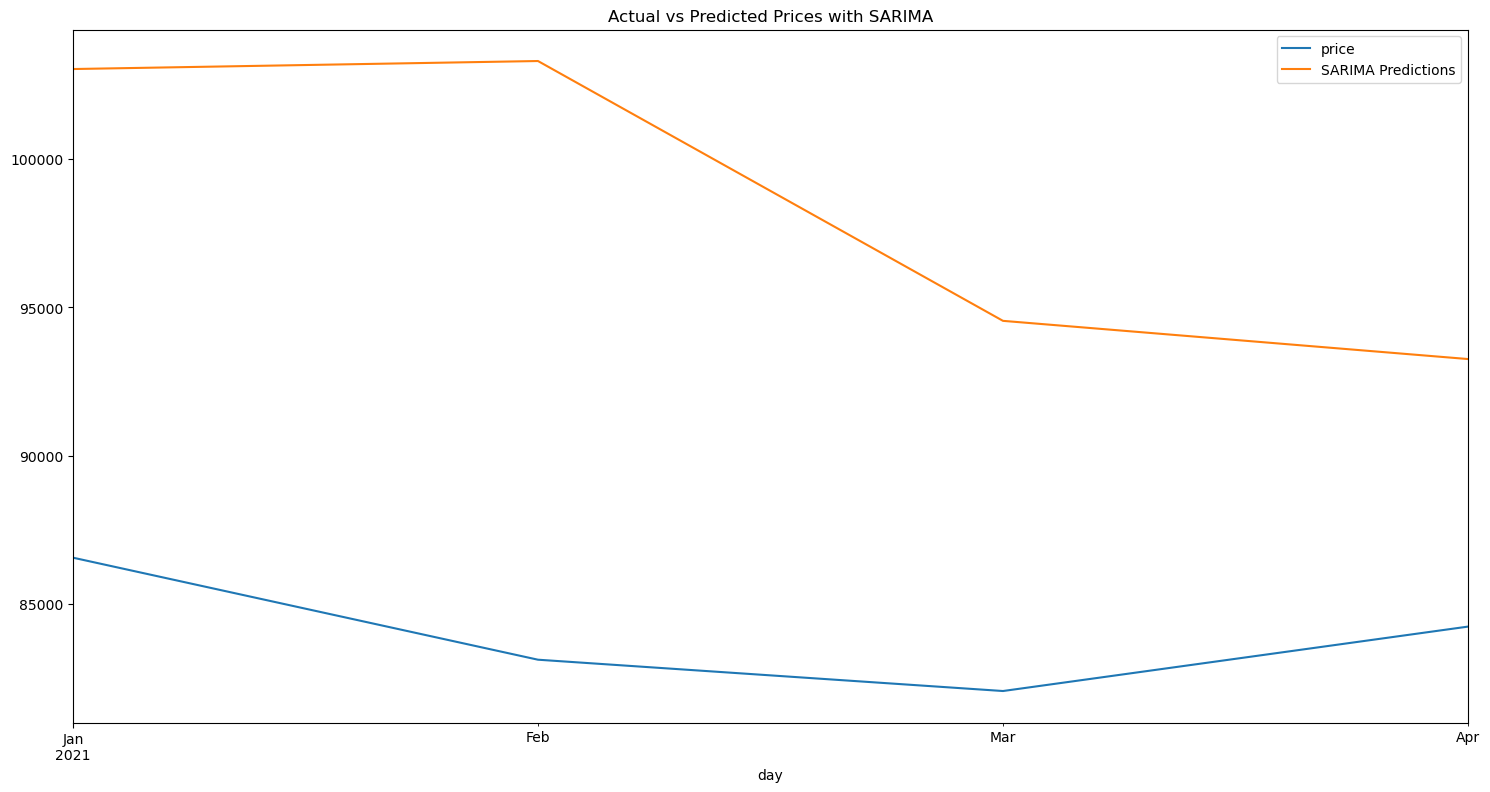

In [25]:
# Define the seasonal order parameters
seasonal_order = (1,1,1,12)

# Build and train the SARIMA model
sarima_model = sm.tsa.statespace.SARIMAX(train_data['price'],
                                         order=(1,1,1),
                                         seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

# Predict using the model
sarima_pred = sarima_result.predict(start=len(train_data), end=len(samsung_monthly)-1, typ="levels").rename("SARIMA Predictions")

# Plot the actual vs predicted values
plt.figure(figsize=(18,9))
test_data['price'].plot(legend=True)
sarima_pred.plot(legend=True)
plt.title('Actual vs Predicted Prices with SARIMA')
plt.show()


In [27]:
sarima_rmse_error = np.sqrt(mean_squared_error(test_data['price'], sarima_pred))
sarima_mse_error = sarima_rmse_error**2

sarima_mse_error, sarima_rmse_error

(228631744.30770606, 15120.573544270934)